## Test et anlyse du modèle DIST_REL_C_01

De la même façon que nous avons procédé pour le modèle DIST_REL_C_RNN_01, nous allons créer des représentations graphiques des performances, puis nous allons comparer les deux modèles.

#### Chemins des fichiers et constantes

In [1]:

model_loc = "../models/DIST_REL_C_01/11.0/DIST_REL_C_01_basic.tflearn"

figures_loc = "../figures/11.1-"
model_name = "DIST_REL_C_01"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/test_set_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/test_set_labels.h5"

train_riken_reduced_loc = "../data/train_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/test_set_riken_v2_reduced.h5"

test_tailles_CC_loc = "../data/stats/CC/CC_bonds_lengths_minimal.h5"

"""
train_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/minimal_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/minimal_labels.h5"
"""

'\ntrain_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"\ntest_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"\n\ntest_set_prepared_input_loc = "../data/DIST_REL_C_RNN/minimal_prepared_input.h5"\ntest_set_labels_loc = "../data/DIST_REL_C_RNN/minimal_labels.h5"\n'

#### Constantes

In [2]:
C_ANUM = 6.
O_ANUM = 8.
H_ANUM = 1.

### Création du RN

#### Fonction de coût (RMSE)

In [2]:
def rmse(pred, targets):
    with tf.name_scope("rmse_loss"):
        return tf.sqrt(tf.reduce_mean(tf.squared_difference(pred, targets)), name="rmse")

#### Fonction d'évaluation des performances (opposé du RMSE)

In [3]:
def rmse_valid(pred, targets, inputs):
    with tf.name_scope("rmse_validation"):
        return -rmse(pred, targets)

#### Fonction de création du RN


In [4]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.optimizers import Adam
from tflearn.data_preprocessing import DataPreprocessing
import math


def creer_RN(epsilon=1e-8, learning_rate=0.001, dropout_val=0.99, stddev_init=0.001,
             hidden_act='relu', outlayer_act='prelu', weight_decay=0.001, width=870, depth=3,
             validation_fun=rmse_valid, cost_fun=rmse):

    # On créé l'initialisateur de tenseur avec une loi normale tronquée. sigma = stddev_init, et les 
    # valeurs à plus de 2sigma sont re-tirées
    winit = tfl.initializations.truncated_normal(stddev=stddev_init, dtype=tf.float32, seed=None)
    
    # On créé l'input du RN
    network = input_data(shape=[None, 870], name='input')
    
    # On créé les couches cachées
    for i in range(depth):
        network = fully_connected(network, width, activation=hidden_act, name='fc'+str(i), weights_init=winit,
                                  weight_decay=weight_decay)
        # On détruit des neurones aléatoirement avec une la probabilité donnée en entrée
        network = dropout(network, dropout_val)
    
    # On ajoute la couche de sortie du réseau
    # Fonction d'activation prelu
    # Initilisée avec la loi normale tronquée
    network = fully_connected(network, 1, activation=outlayer_act, name='outlayer', weights_init=winit)
    
    adam = Adam(learning_rate=learning_rate, epsilon=epsilon)
    
    # Couche d'évaluation du modèle. Utilisation d'une descente stochastique Adam
    # Learning rate = 0.05
    # Loss = fonction définie rmse
    network = regression(network, optimizer=adam,
    loss=cost_fun, metric=validation_fun, name='target')
            
    return network

/home/etudiant/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Calcul des prédictions

#### Calcul du RMSE sur des vecteurs

In [5]:
import numpy as np

def rmse_test(targets, predictions):
    return np.sqrt(np.square(np.diff([targets, predictions], axis=0)))[0]

#### Calcul de l'erreur sur chaque exemple du jeu de test

In [6]:
import h5py
from tflearn.data_utils import pad_sequences
import tensorflow as tf
import tflearn as tfl

def calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc):
    """ Renvoie l'erreur et la prédiction pour chaque exemple du jeu de test """
    
    tf.reset_default_graph()
    
    # Importation du modèle
    network = creer_RN(learning_rate=0.01, dropout_val=0.98, epsilon=0.001, hidden_act="elu", outlayer_act="linear", width=870, depth=3)
    model = tfl.DNN(network)
    model.load(model_loc, weights_only=True)
    
    # Chargement des données
    inputs_h5 = h5py.File(test_set_prepared_input_loc, 'r')
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    
    inputs = np.array(inputs_h5["inputs"])
    inputs = pad_sequences(inputs, dtype="float32", maxlen=870)
    inputs = inputs.reshape(-1, 870)
    
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    
    predictions = model.predict(inputs)
    
    return rmse_test(targets, predictions).reshape(1, -1)[0], predictions
    
    

In [7]:
rmses, predictions = calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc)


INFO:tensorflow:Restoring parameters from /home/etudiant/Documents/Cours/TER/Notebooks/TERQuChemPedIA/models/DIST_REL_C_01/11.0/DIST_REL_C_01_basic.tflearn


InternalError: Blas GEMM launch failed : a.shape=(5635, 870), b.shape=(870, 870), m=5635, n=870, k=870
	 [[Node: fc0/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input/X_0_0/_27, fc0/W/read)]]
	 [[Node: outlayer/BiasAdd/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_95_outlayer/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'fc0/MatMul', defined at:
  File "/home/etudiant/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/etudiant/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-3cc2320a2610>", line 1, in <module>
    rmses, predictions = calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc)
  File "<ipython-input-6-ee07c779964a>", line 12, in calculer_pred
    network = creer_RN(learning_rate=0.01, dropout_val=0.98, epsilon=0.001, hidden_act="elu", outlayer_act="linear", width=870, depth=3)
  File "<ipython-input-4-5278e6da0b04>", line 22, in creer_RN
    weight_decay=weight_decay)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tflearn/layers/core.py", line 181, in fully_connected
    inference = tf.matmul(inference, W)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2108, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4209, in mat_mul
    name=name)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/etudiant/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(5635, 870), b.shape=(870, 870), m=5635, n=870, k=870
	 [[Node: fc0/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input/X_0_0/_27, fc0/W/read)]]
	 [[Node: outlayer/BiasAdd/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_95_outlayer/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


#### Affichage des statistiques sur les erreurs

In [ ]:
def print_stats_rmse(rmses):
    print("Erreur moyenne : "+str(np.mean(rmses)))
    print("Erreur médiane : "+str(np.median(rmses)))
    print("Écart-type : "+str(np.std(rmses)))
    print("Erreur min : "+str(min(rmses)))
    print("Erreur max : "+str(max(rmses)))
    
print_stats_rmse(rmses)

##### Sortie

```
Erreur moyenne : 12.826389
Erreur médiane : 6.0214844
Écart-type : 20.240458
Erreur min : 0.0
Erreur max : 285.42126
```

### Analyse

On voit ici que le modèle produit en général de bons résultats. La moitié des erreurs est en dessous de 6 mÅ ce qui correspond à une grande précision des estimations.

Toutefois, on remarque que le modèle produit également de grandes erreurs sur certaines liaisons et que l'écart-type est élevé par rapport à l'ordre de grandeur de la médiane.

On a donc un modèle qui prédit très bien la moitié des données, et qui prédit mal l'autre moitié. Nous allons tenter de comprendre quelles sont les valeurs typiques qui sont bien ou mal prédites.

#### Récupération du vecteur cibles (distances)

In [ ]:
def extract_targets(test_set_labels_loc):
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    return targets

targets = extract_targets(test_set_labels_loc)


### Représentation graphique de la distribution des erreurs selon leur valeur

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000


def plot_distrib_rmses_val(rmses, padding, model_name, figures_loc):
    """ Affiche la distribution des rmses selon un pas donné """
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(rmses))
    fin_index = max(rmses)+padding
    
    # On créé l'index des rmses
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur de rmses
    rmse_occ = np.zeros_like(index)
        
    # Calcul des rmse
    for rmse in rmses:
        rmse_occ[int((rmse-debut_index)/padding)] += 1
    
    fig = plt.figure()
    
    
    ## Échelle linéaire ##
    ax1 = fig.add_subplot(121)
    ax1.set_title("Modèle "+model_name+"\n Distribution des erreurs")
    ax1.set_xlabel("Erreur absolue (mÅ)")
    ax1.set_ylabel("Occurrences sur le jeu de test")
    ax1.bar(index, rmse_occ)
   

    ## Échelle logarithmique
    ax2 = fig.add_subplot(122)
    ax2.set_title("Modèle "+model_name+"\n Distribution des erreurs")
    ax2.set_xlabel("Erreur absolue (mÅ)")
    ax2.set_ylabel("Occurrences sur le jeu de test (échelle logarithmique)")
    ax2.set_yscale("log")
    ax2.bar(index, rmse_occ)
    
    plt.gcf().subplots_adjust(wspace=0.3)

    
    plt.savefig(figures_loc+model_name+"_distrib_rmse_val.png", dpi=200)
    plt.show()



In [ ]:
#plot_distrib_rmses_val(rmses, 1, model_name, figures_loc)

![title](../figures/11.1-DIST_REL_C_01_distrib_rmse_val.png)


### Analyse

Ce graphe confirme d'une part que la plupart des prédictions du modèle sont en général très proches des valeurs attendues, et d'autre part que le modèle fait de très grosses erreurs sur certaines prédictions.

#### Récupération des distances CC dans le jeu de test

In [ ]:
import h5py
import numpy as np

dist_CC_test_h5 = h5py.File(test_tailles_CC_loc, 'r')
dists = np.array(dist_CC_test_h5["distances"])

#### Distribution des erreurs selon la distance à prédire

In [136]:
import numpy as np
from matplotlib import gridspec

def plot_rmse_distrib_dist(rmses, targets, anum_1, anum_2, model_name, figures_loc, dists, padding):
    
    fig = plt.figure()
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
        
    ax = plt.subplot(gs[0])

    
    ax.set_title("Modèle "+model_name+"\nDistribution des erreurs selon les distances cibles")
    ax.set_xlabel("Distance cible (mÅ)")
    ax.set_ylabel("Erreur absolue (mÅ)")
    ax.plot(targets, rmses, ",", label="Erreur absolue (mÅ)")
    
    ax.set_xlim(xmin=min(targets), xmax=max(targets))

    
    ax2 = plt.subplot(gs[1])
    
    #ax2.set_xlim(xmin=min(targets), xmax=max(targets))
            
    # Passage des distances en mÅ
    dists = dists*1000
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(targets))
    fin_index = max(targets)+padding
    
    # On créé l'index
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur d'occurences
    dists_occ = np.zeros_like(index)
    
    max_targets = max(targets)
    
    # Calcul des occurences
    for dist in dists:
        if dist < max_targets :
            dists_occ[int((dist-debut_index)/padding)] += 1
                                    
    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    cmap = mpl.cm.binary
    norm = mpl.colors.Normalize()

    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, values=dists_occ,
                                    norm=norm,
                                    orientation='horizontal')
    
    cb1.set_label('Représentation des longueurs de liaisons')

    plt.tight_layout()

        
    plt.savefig(figures_loc+model_name+"_distrib_rmse_dist.png", dpi=250)
    
    plt.show()
    


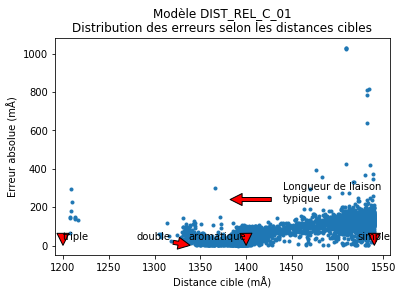

In [137]:
plot_rmse_distrib_dist(rmses, targets, C_ANUM, C_ANUM, model_name, figures_loc, dists, 1)

![title](../figures/11.1-DIST_REL_C_01_distrib_rmse_dist.png)


### Analyse

On visualise ici l'erreur absolue en fonction de la distance cible. Cela permet de visualiser quelles sont les classes de liaisons covalentes (simple, aromatique, double et triple) qui sont le mieux prédites par le modèle.

On remarque premièrement que pour toutes les classes, la densité est très forte sur les erreurs faibles (50% des valeurs sont en dessous de la droite x=6, cf. médiane).

On remarque que les liaisons aromatiques sont les mieux prédites, ce qui est cohérent avec le fait que ce sont les plus représentées dans les données. Les liaisons simples sont légèrement moins bien prédites et les liaisons doubles et triples sont les plus mal prédites.

Contrairement au modèle DIST_REL_C_RNN_01 (voir notebook 9.3), ce modèle semble généralement capable de *comprendre* l'existence des différentes classes de liaisons, et de produire des prédictions fonctions de la classe de la liaison. On remarque toutefois que le modèle prédit par défaut une liaison aromatique lorsqu'il n'arrive pas à *déduire* la classe de la liaison.

#### Visualisation des prédictions selon les distances attendues

In [1]:
def fun_id(x):
    return x

def plot_targets_pred(targets, preds, anum_1, anum_2, model_name, figures_loc):
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
        
    ax.set_title("Modèle "+model_name+"\n Prédictions en fonction des distances cibles")
    ax.set_xlabel("Distance cible (mÅ)")
    ax.set_ylabel("Distance prédite (mÅ)")
    
    ax.plot(targets, preds, ",")
    
    """
    ax.annotate('', xy=(0.07, 0.89), xytext=(0.17, 0.89), xycoords=ax.transAxes,
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    ax.text(0.19, 0.85, "Longueur de liaison\ntypique", transform=ax.transAxes)
    """
    if anum_1==C_ANUM and anum_2==C_ANUM:
        
        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((1200,0)))[0]
        ax.annotate('triple', xy=(x_axe_coord, 0), xytext=(x_axe_coord+0.06, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05), label="Longeur de liaison typique"
                )

        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((1340,0)))[0]
        ax.annotate('double', xy=(x_axe_coord, 0), xytext=(x_axe_coord, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05),
                )

        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((1540,0)))[0]
        ax.annotate('simple', xy=(x_axe_coord, 0), xytext=(x_axe_coord, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05),
                )

        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((1400,0)))[0]
        ax.annotate('aromatique', xy=(x_axe_coord, 0), xytext=(x_axe_coord, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05),
                )

    elif anum_1==C_ANUM and anum_2==H_ANUM:
        
        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((1090,0)))[0]
        ax.annotate('simple', xy=(x_axe_coord, 0), xytext=(x_axe_coord, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05), label="Longueur de liaison typique"
                )
        
    elif anum_1==O_ANUM and anum_2==H_ANUM:
        
        x_axe_coord = ax.transAxes.inverted().transform(ax.transData.transform((980,0)))[0]
        ax.annotate('simple', xy=(x_axe_coord, 0), xytext=(x_axe_coord, 0.1), xycoords=ax.transAxes,
                arrowprops=dict(facecolor='red', shrink=0.05), label="Longueur de liaison typique"
                )
        
        
    # On trace la droite y=x
    x=np.linspace(min(targets), max(targets))
    ax.plot(x, fun_id(x), color='darkgreen', label="Modèle théorique parfait")
    
    ax.text(0.65, 0.85, 'Modèle théorique\nparfait',
        transform=ax.transAxes,
        color='darkgreen')
    
    ax.legend(loc='upper center', shadow=True)
    
    plt.savefig(figures_loc+model_name+"_preds_fonction_cibles.png", dpi=250)
    
    plt.show()



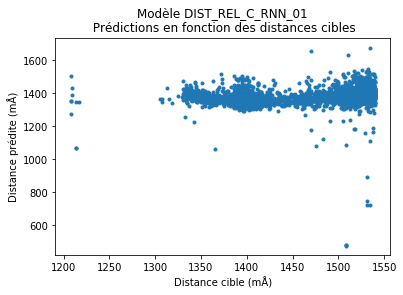

In [139]:
plot_targets_pred(targets, predictions, C_ANUM, C_ANUM, model_name, figures_loc)

![title](../figures/11.1-DIST_REL_C_01_preds_fonction_cibles.png)


### Analyse

On visualise ici les distances prédites par le modèle en fonction des distances qu'il devait prédire. Un modèle parfait ne produirait donc que des prédictions sur la droite y=x. Ici, on remarque que les densités de prédictions les plus importantes se trouvent sur cette droite, mais que beaucoup de prédictions sont toutefois en dehors.

On remarque également que le modèle a tendance à *confondre* les liaisons aromatiques et les liaisons simples, ce qui est intéressant car on pourrait peut-être obtenir de meilleurs résultats en l'aidant à trouver les classes de liaisons.

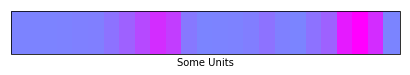

In [13]:

import matplotlib.pyplot as plt
import matplotlib as mpl



plt.show()